# Load the model

In [1]:
import os
import numpy as np
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from utils.dirs import listdir_nohidden
from utils.factory import create
from utils.logger import Logger
from utils.dirs import create_dirs
# test list 
anomalous_dir = "data/Anomalous"
images = os.path.join(anomalous_dir, "images")
taggers = os.path.join(anomalous_dir, "gt")
image_list = listdir_nohidden(images)
dir_image_list = [os.path.join(images,x) for x in image_list]
corr_tag_list = listdir_nohidden(taggers)
dir_corr_tag_list = [os.path.join(taggers,x) for x in corr_tag_list]
image_tag_list = list(zip(dir_image_list, dir_corr_tag_list))
print(image_tag_list[:5])

# Load the model
import tensorflow as tf
init = tf.global_variables_initializer()
from utils.config import process_config
config_file = 'configs/ganomaly.json'
config = process_config(config_file,"ganomaly_patch28_long")
create_dirs(
        [
            #config.log.summary_dir,
            #config.log.checkpoint_dir,
            config.log.step_generation_dir,
            config.log.log_file_dir,
            config.log.codebase_dir,
        ]
    )
#l = Logger(config)
#logger = l.get_logger(__name__)
# Create the tensorflow session
sess = tf.Session()
# Create the dataloader
data = create("data_loader." + config.data_loader.name)(config)




[('data/Anomalous/images/ITIA1101.tif', 'data/Anomalous/gt/ITIA1101_gt.png'), ('data/Anomalous/images/ITIA1102.tif', 'data/Anomalous/gt/ITIA1102_gt.png'), ('data/Anomalous/images/ITIA1103.tif', 'data/Anomalous/gt/ITIA1103_gt.png'), ('data/Anomalous/images/ITIA1104.tif', 'data/Anomalous/gt/ITIA1104_gt.png'), ('data/Anomalous/images/ITIA1105.tif', 'data/Anomalous/gt/ITIA1105_gt.png')]
2019-04-27 13:30:35,643 — utils.DataLoader — INFO — Train and Validation datasets are already populated
2019-04-27 13:30:35,644 — utils.DataLoader — INFO — Test Dataset is already populated
2019-04-27 13:30:35,645 — data_loader.data_generator — INFO — Data is loading...
2019-04-27 13:30:36,089 — utils.DataLoader — INFO — Train Dataset is Loaded
2019-04-27 13:30:36,232 — utils.DataLoader — INFO — Validation Dataset is Loaded


In [2]:
sess.run(data.test_iterator.initializer)

In [30]:
def extract_regions(input_imgs,size):
    imgs_tags = []
    top = 0
    left = 0
    h, w = input_imgs[0].shape[:2]
    w_turns = w // size
    h_turns = h // size
    for adv_h in range(h_turns):
        for adv_w in range(w_turns):
            image = input_imgs[0][adv_h * size :(adv_h +1) * size , adv_w * size : (adv_w + 1 ) * size]
            tag = input_imgs[1][adv_h * size :(adv_h +1) * size , adv_w * size : (adv_w + 1 ) * size]
            imgs_tags.append((image,tag))
    return imgs_tags, (h_turns,w_turns)
def read_image_tuple(img):
    return [io.imread(img[0]),io.imread(img[1])]

ext_img, turns = extract_regions(read_image_tuple(image_tag_list[1]),size=28)

In [31]:
def show_images_from_files(image_tuple):
    for images in image_tuple:
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(io.imread(images[0]),cmap="gray")
        ax1 = fig.add_subplot(1,2,2)
        ax1.imshow(io.imread(images[1]),cmap="gray")
        
def show_images_from_memory(image_tuple):
    for images in image_tuple:
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow((images[0]),cmap="gray")
        ax1 = fig.add_subplot(1,2,2)
        ax1.imshow((images[1]),cmap="gray")

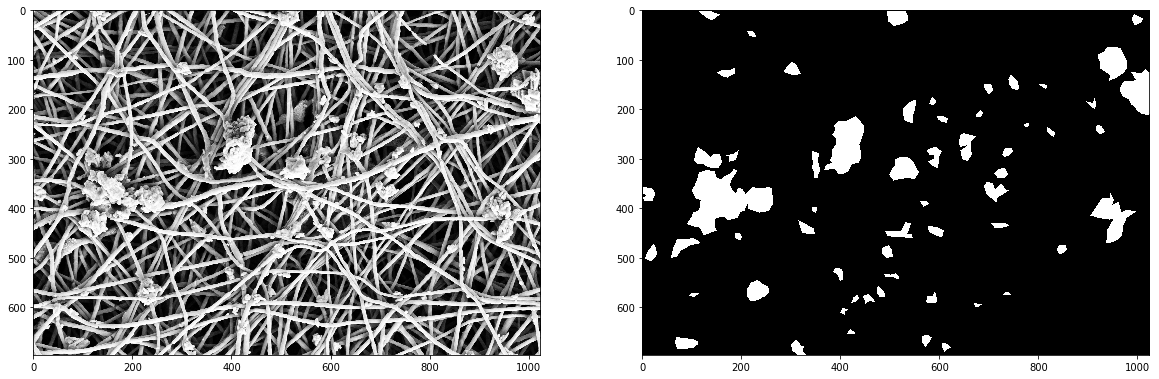

In [32]:
show_images_from_files(image_tag_list[1:2])

In [42]:
test_image = image_tag_list[1]
ext_img, turns = extract_regions(read_image_tuple(test_image),size=28)
test_batch = np.ndarray(shape=[864,28,28,1])
for i in range(864):
    test_batch[i,:,:,0] = ext_img[i][0]
#test_batch[:] = ext_img[:][0]

In [45]:
# Create the model instance
model = create("models." + config.model.name)(config)
# Create the summarizer Object
summarizer = create("utils." + config.log.name)(sess, config)
# Create the trainer
trainer = create("trainers." + config.trainer.name)(sess, model, data, config, summarizer)
# Load model if exists
model.load(sess)

2019-04-27 13:41:27,516 — base.base_model — INFO — Building training graph...
2019-04-27 13:41:33,300 — base.base_model — INFO — Building Testing Graph...
2019-04-27 13:41:43,112 — base.base_model — INFO — Loading model checkpoint Experiments/ganomaly_patch28_long/checkpoint/-27200 ...

INFO:tensorflow:Restoring parameters from Experiments/ganomaly_patch28_long/checkpoint/-27200
2019-04-27 13:41:43,891 — base.base_model — INFO — Model loaded


In [ ]:
# Make the inference
feed_dict = {model.image_input: test_batch, model.is_training: False}
noise_gen, img_rec, noise_rec = sess.run([model.noise_gen, model.img_rec, model.noise_rec], feed_dict=feed_dict)



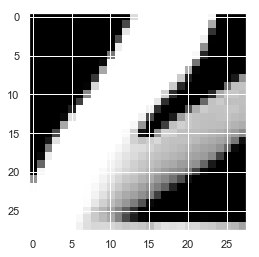